In [1]:
import torch
import time
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet

# define the dataset

In [2]:
# root = '/Users/smiffy/Documents/GitHub/TUSIMPLE/Data_Tusimple_PyTorch/training'
root = './TUSIMPLE/txt_for_local'
train_set = TUSIMPLE(root=root, flag='train')
valid_set = TUSIMPLE(root=root, flag='valid')
test_set = TUSIMPLE(root=root, flag='test')

print('train_set length {}'.format(len(train_set)))
print('valid_set length {}'.format(len(valid_set)))
print('test_set length {}'.format(len(test_set)))

train_set length 396
valid_set length 49
test_set length 50


In [3]:
gt, bgt, igt = train_set[0]
print('image type {}'.format(type(gt)))
print('image size {} \n'.format(gt.size()))

print('gt binary image type {}'.format(type(bgt)))
print('gt binary image size {}'.format(bgt.size()))
print('items in gt binary image {} \n'.format(torch.unique(bgt)))

print('gt instance type {}'.format(type(igt)))
print('gt instance size {}'.format(igt.size()))
print('items in gt instance {} \n'.format(torch.unique(igt)))

image type <class 'torch.Tensor'>
image size torch.Size([3, 256, 512]) 

gt binary image type <class 'torch.Tensor'>
gt binary image size torch.Size([256, 512])
items in gt binary image tensor([0, 1]) 

gt instance type <class 'torch.Tensor'>
gt instance size torch.Size([256, 512])
items in gt instance tensor([ 0, 20]) 



# DataLoader

In [4]:
batch_size = 8

In [5]:
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_valid = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=True, num_workers=0)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

# Model and optim

In [6]:
learning_rate = 5e-4

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

LaneNet_model = Lanenet(2, 4)
LaneNet_model.to(device)

params = [p for p in LaneNet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
num_epochs = 30

In [9]:
from Lanenet.cluster_loss3 import cluster_loss
criterion = cluster_loss()
# criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([ 1.4393, 27.7296]).cuda())

In [10]:
from torch.autograd import Variable

In [11]:
loss_all = []
for epoch in range(num_epochs):
    LaneNet_model.train()
    ts = time.time()
    for iter, batch in enumerate(data_loader_train):
        input_image = Variable(batch[0]).to(device)
        binary_labels = Variable(batch[1]).to(device)
        instance_labels = Variable(batch[2]).to(device)
        
        binary_final_logits, instance_embedding = LaneNet_model(input_image)
        # loss = LaneNet_model.compute_loss(binary_logits=binary_final_logits, binary_labels=binary_labels,
        #                               instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        binary_segmenatation_loss, instance_segmenatation_loss = criterion(binary_logits=binary_final_logits, binary_labels=binary_labels,
                                       instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        
        # binary_segmenatation_loss = criterion(binary_final_logits, binary_labels)
        loss = 1*binary_segmenatation_loss + 1*instance_segmenatation_loss
        optimizer.zero_grad()
        loss_all.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if iter % 20 == 0:
            print("epoch[{}] iter[{}] loss: [{}, {}] ".format(epoch, iter, binary_segmenatation_loss.item(), instance_segmenatation_loss.item()))
    lr_scheduler.step()
    print("Finish epoch[{}], time elapsed[{}]".format(epoch, time.time() - ts))
    torch.save(LaneNet_model.state_dict(), 
                       f"TUSIMPLE/Lanenet_output/lanenet_epoch_{epoch}_batch_{8}.model")

epoch[0] iter[0] loss: [0.7530289888381958, 9.256881713867188] 
epoch[0] iter[20] loss: [0.5697964429855347, 7.709800720214844] 
epoch[0] iter[40] loss: [0.42561885714530945, 4.542596340179443] 
Finish epoch[0], time elapsed[36.44971323013306]
epoch[1] iter[0] loss: [0.3955254852771759, 3.320457935333252] 
epoch[1] iter[20] loss: [0.28516489267349243, 2.8357832431793213] 
epoch[1] iter[40] loss: [0.23882745206356049, 1.999981164932251] 
Finish epoch[1], time elapsed[35.85124397277832]
epoch[2] iter[0] loss: [0.21853896975517273, 2.4046168327331543] 
epoch[2] iter[20] loss: [0.19768239557743073, 2.7204604148864746] 
epoch[2] iter[40] loss: [0.1631418615579605, 1.6718729734420776] 
Finish epoch[2], time elapsed[35.77337694168091]
epoch[3] iter[0] loss: [0.1433662325143814, 1.9678171873092651] 
epoch[3] iter[20] loss: [0.13130708038806915, 1.2759093046188354] 
epoch[3] iter[40] loss: [0.09495431929826736, 0.8929114937782288] 
Finish epoch[3], time elapsed[35.79238438606262]
epoch[4] iter[

## Show the Loss

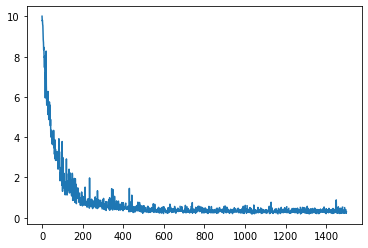

In [12]:
import matplotlib.pylab as plt
plt.plot(loss_all)